In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import lit
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

In [2]:
spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

In [3]:
input = 'EDS_4.csv'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

In [4]:
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,Z from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

temp.show()

+--------------------+---------+
|           timestamp|        Z|
+--------------------+---------+
|2018-07-09 12:00:...|-1.070313|
|2018-07-09 12:00:...|-1.074219|
|2018-07-09 12:00:...|  -1.0625|
|2018-07-09 12:00:...|-1.066406|
|2018-07-09 12:00:...|-1.074219|
|2018-07-09 12:00:...|-1.074219|
|2018-07-09 12:00:...|  -1.0625|
|2018-07-09 12:00:...|-1.058594|
|2018-07-09 12:00:...|-1.058594|
|2018-07-09 12:00:...|-1.066406|
|2018-07-09 12:00:...|  -1.0625|
|2018-07-09 12:00:...|-1.066406|
|2018-07-09 12:00:...|-1.070313|
|2018-07-09 12:00:...|-1.066406|
|2018-07-09 12:00:...|  -1.0625|
|2018-07-09 12:00:...|-1.070313|
|2018-07-09 12:00:...|  -1.0625|
|2018-07-09 12:00:...|-1.066406|
|2018-07-09 12:00:...|-1.070313|
|2018-07-09 12:00:...|  -1.0625|
+--------------------+---------+
only showing top 20 rows



In [5]:
#since elevator 4 sensor is fixed in negetive axis
temp = temp.withColumn("Z", temp['Z']*(-1))

temp.show()

+--------------------+--------+
|           timestamp|       Z|
+--------------------+--------+
|2018-07-09 12:00:...|1.070313|
|2018-07-09 12:00:...|1.074219|
|2018-07-09 12:00:...|  1.0625|
|2018-07-09 12:00:...|1.066406|
|2018-07-09 12:00:...|1.074219|
|2018-07-09 12:00:...|1.074219|
|2018-07-09 12:00:...|  1.0625|
|2018-07-09 12:00:...|1.058594|
|2018-07-09 12:00:...|1.058594|
|2018-07-09 12:00:...|1.066406|
|2018-07-09 12:00:...|  1.0625|
|2018-07-09 12:00:...|1.066406|
|2018-07-09 12:00:...|1.070313|
|2018-07-09 12:00:...|1.066406|
|2018-07-09 12:00:...|  1.0625|
|2018-07-09 12:00:...|1.070313|
|2018-07-09 12:00:...|  1.0625|
|2018-07-09 12:00:...|1.066406|
|2018-07-09 12:00:...|1.070313|
|2018-07-09 12:00:...|  1.0625|
+--------------------+--------+
only showing top 20 rows



### Plot of raw data

In [6]:
temp.createOrReplaceTempView("rawData")
raw_df = spark.sql("select timestamp,Z from rawData where timestamp between '2018-07-10 14:18:00' and '2018-07-10 14:18:10'").cache()

In [7]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [8]:
%time raw_pandas = raw_df.select("*").toPandas()

/home/kenny/Softwares/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


CPU times: user 65.4 ms, sys: 109 ms, total: 175 ms
Wall time: 2min 25s


(array([  0.,  50., 100., 150., 200., 250.]),
 <a list of 6 Text xticklabel objects>)

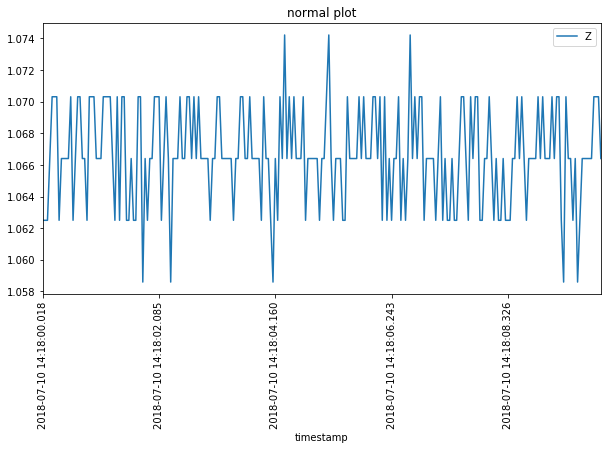

In [9]:
raw_pandas.plot(x ='timestamp', y='Z', kind = 'line', figsize=(10,5))
plt.title("normal plot")
plt.xticks(rotation=90)

In [6]:
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|1.070313|  0.81591|
|2018-07-09 12:00:...|1.074219| 1.438691|
|2018-07-09 12:00:...|  1.0625|-0.429811|
|2018-07-09 12:00:...|1.066406|  0.19297|
|2018-07-09 12:00:...|1.074219| 1.438691|
|2018-07-09 12:00:...|1.074219| 1.438691|
|2018-07-09 12:00:...|  1.0625|-0.429811|
|2018-07-09 12:00:...|1.058594|-1.052592|
|2018-07-09 12:00:...|1.058594|-1.052592|
|2018-07-09 12:00:...|1.066406|  0.19297|
|2018-07-09 12:00:...|  1.0625|-0.429811|
|2018-07-09 12:00:...|1.066406|  0.19297|
|2018-07-09 12:00:...|1.070313|  0.81591|
|2018-07-09 12:00:...|1.066406|  0.19297|
|2018-07-09 12:00:...|  1.0625|-0.429811|
|2018-07-09 12:00:...|1.070313|  0.81591|
|2018-07-09 12:00:...|  1.0625|-0.429811|
|2018-07-09 12:00:...|1.066406|  0.19297|
|2018-07-09 12:00:...|1.070313|  0.81591|
|2018-07-09 12:00:...|  1.0625|-0.429811|
+--------------------+--------+---

In [11]:
scaledData.sort(desc("Zscale")).show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-10 16:10:...| 1.34375|44.798147|
|2018-07-10 16:10:...|1.332031|42.913377|
|2018-07-26 11:17:...|1.304688|38.515795|
|2018-07-26 11:17:...|1.253906|30.348512|
|2018-07-18 17:43:...| 1.21875|24.694363|
|2018-07-10 16:10:...|1.214844| 24.06616|
|2018-07-13 11:24:...|1.214844| 24.06616|
|2018-08-01 09:29:...|1.214844| 24.06616|
|2018-07-25 17:53:...|1.210938|23.437957|
|2018-07-23 17:35:...|1.210938|23.437957|
|2018-07-09 14:48:...|1.210938|23.437957|
|2018-07-16 14:18:...|1.210938|23.437957|
|2018-07-17 17:34:...|1.207031|22.809593|
|2018-07-24 22:24:...|1.207031|22.809593|
|2018-07-12 14:44:...|1.207031|22.809593|
|2018-08-02 17:44:...|1.207031|22.809593|
|2018-07-13 11:24:...|1.203125| 22.18139|
|2018-07-23 08:37:...|1.203125| 22.18139|
|2018-07-18 09:04:...|1.203125| 22.18139|
|2018-07-23 15:01:...|1.203125| 22.18139|
+--------------------+--------+---

In [12]:
scaledData.sort("Zscale").show()

+--------------------+--------+----------+
|           timestamp|       Z|    Zscale|
+--------------------+--------+----------+
|2018-07-26 11:17:...|0.628906|-70.170407|
|2018-07-10 16:10:...|0.667969|-63.887894|
|2018-08-01 09:29:...|0.699219|-58.861948|
|2018-07-10 16:10:...| 0.78125| -45.66888|
|2018-07-10 16:10:...|0.789063|-44.412313|
|2018-07-26 11:17:...|  0.8125|-40.642934|
|2018-07-10 16:10:...|0.832031|-37.501758|
|2018-07-10 16:10:...|0.835938|-36.873395|
|2018-07-10 16:10:...| 0.84375|-35.616988|
|2018-07-30 14:44:...|0.851563|-34.360422|
|2018-07-10 16:10:...|0.859375|-33.104015|
|2018-07-26 11:17:...|0.863281|-32.475812|
|2018-07-26 11:17:...|0.863281|-32.475812|
|2018-08-01 09:29:...|0.871094|-31.219246|
|2018-08-01 09:29:...|0.882813|-29.334476|
|2018-08-01 09:29:...|0.882813|-29.334476|
|2018-07-26 11:17:...|0.886719|-28.706273|
|2018-07-26 11:17:...|0.894531|-27.449866|
|2018-07-26 11:17:...|0.894531|-27.449866|
|2018-08-01 09:29:...|0.894531|-27.449866|
+----------

In [7]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Zscale from scaledData where timestamp between '2018-07-10 16:10:00' and '2018-07-10 16:11:00'").cache()

In [8]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+--------------------+---------+-------------------+
|           timestamp|   Zscale|         timestamp1|
+--------------------+---------+-------------------+
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:

In [85]:
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-1,1))).cache()
movAvg.show()

+--------------------+---------+-------------------+--------------------+
|           timestamp|   Zscale|         timestamp1|       movingAverage|
+--------------------+---------+-------------------+--------------------+
|2018-07-10 16:10:...| -1.06357|2018-07-10 16:10:47|          -1.3776715|
|2018-07-10 16:10:...|-1.691773|2018-07-10 16:10:47| -1.4823719999999998|
|2018-07-10 16:10:...|-1.691773|2018-07-10 16:10:47| -1.9012276666666665|
|2018-07-10 16:10:...|-2.320137|2018-07-10 16:10:47| -0.4353670000000001|
|2018-07-10 16:10:...| 2.705809|2018-07-10 16:10:47|  1.4493493333333334|
|2018-07-10 16:10:...| 3.962376|2018-07-10 16:10:47|            2.077606|
|2018-07-10 16:10:...|-0.435367|2018-07-10 16:10:47| 0.40229066666666674|
|2018-07-10 16:10:...|-2.320137|2018-07-10 16:10:47|-0.22596599999999997|
|2018-07-10 16:10:...| 2.077606|2018-07-10 16:10:47|  0.6116916666666666|
|2018-07-10 16:10:...| 2.077606|2018-07-10 16:10:47|  1.4493493333333332|
|2018-07-10 16:10:...| 0.192836|2018-0

### Data Plot

In [31]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Zscale from scaledData where timestamp between '2018-07-10 16:10:00' and '2018-07-10 16:11:00'").cache()

In [32]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+--------------------+---------+-------------------+
|           timestamp|   Zscale|         timestamp1|
+--------------------+---------+-------------------+
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:

In [33]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [34]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 13.1 ms, sys: 3.65 ms, total: 16.8 ms
Wall time: 83.3 ms


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

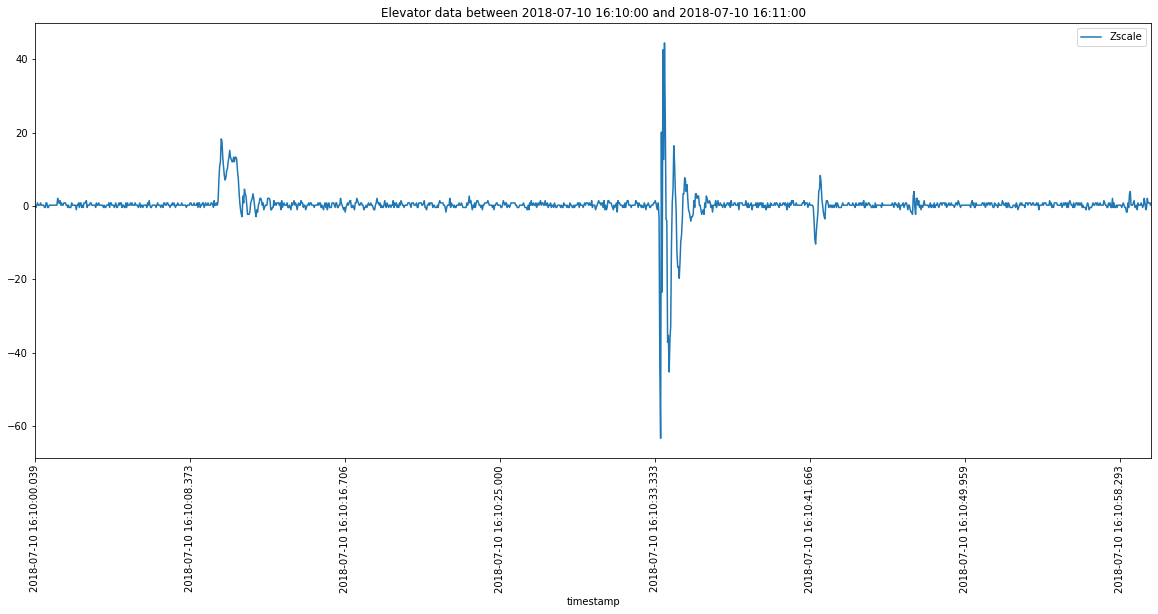

In [35]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(20,8))
plt.title("Elevator data between 2018-07-10 16:10:00 and 2018-07-10 16:11:00")
plt.xticks(rotation=90)

### Normal Anomaly detection

In [38]:
mean = temp_df.groupBy().avg("Zscale").take(1)[0][0]

df_stats = temp_df.select(functions.stddev(col('Zscale')).alias('stdFull')).collect()
std = df_stats[0]['stdFull']

print(mean)
print(std)

0.2885368806384455
4.229056446157807


In [40]:
temp_df = temp_df.withColumn("distance", (temp_df['Zscale']-mean)/std)
temp_df.show()

+--------------------+---------+-------------------+--------------------+
|           timestamp|   Zscale|         timestamp1|            distance|
+--------------------+---------+-------------------+--------------------+
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|-0.16986008339781816|
|2018-07-10 16:10:...|-0.429811|2018-07-10 16:10:00|-0.16986008339781816|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|-0.02259768386994933|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00| 0.12470231269688654|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|-0.02259768386994933|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|-0.02259768386994933|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|-0.02259768386994933|
|2018-07-10 16:10:...|  0.81591|2018-07-10 16:10:00| 0.12470231269688654|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|-0.02259768386994933|
|2018-07-10 16:10:...|  0.19297|2018-07-10 16:10:00|-0.02259768386994933|
|2018-07-10 16:10:...|  0.19297|2018-0

In [41]:
temp_df.createOrReplaceTempView("anomalyData")
anomaly_df = spark.sql("select * from anomalyData where distance > 4 or distance < -4")
anomaly_df.show()

+--------------------+----------+-------------------+-------------------+
|           timestamp|    Zscale|         timestamp1|           distance|
+--------------------+----------+-------------------+-------------------+
|2018-07-10 16:10:...|  18.25489|2018-07-10 16:10:10|  4.248312442290618|
|2018-07-10 16:10:...| 17.631949|2018-07-10 16:10:10|  4.101012209264417|
|2018-07-10 16:10:...| -44.02718|2018-07-10 16:10:33|-10.478866254173617|
|2018-07-10 16:10:...|-63.334662|2018-07-10 16:10:33|-15.044301179389924|
|2018-07-10 16:10:...| 20.123232|2018-07-10 16:10:33|  4.690099404414861|
|2018-07-10 16:10:...|-23.474137|2018-07-10 16:10:33| -5.618906766360939|
|2018-07-10 16:10:...| 42.544778|2018-07-10 16:10:33|  9.991883924309477|
|2018-07-10 16:10:...| 44.413279|2018-07-10 16:10:33| 10.433708483472687|
|2018-07-10 16:10:...| 23.860236|2018-07-10 16:10:33|  5.573748995660007|
|2018-07-10 16:10:...|-37.176272|2018-07-10 16:10:34|  -8.85890490174849|
|2018-07-10 16:10:...| -35.30777|2018-

In [42]:
anomaly_df = anomaly_df.withColumn("anomaly_count", functions.count(anomaly_df["distance"])
             .over( Window.partitionBy(anomaly_df["timestamp1"]))).cache()
final_df = anomaly_df.select('timestamp1', 'anomaly_count').where(anomaly_df['anomaly_count']>5).dropDuplicates()
final_df.show()

+-------------------+-------------+
|         timestamp1|anomaly_count|
+-------------------+-------------+
|2018-07-10 16:10:33|            7|
|2018-07-10 16:10:34|            6|
+-------------------+-------------+



### Plots of Normal data

In [120]:
roundData = scaledData.withColumn("Zround", functions.round(scaledData["Zscale"]).cast('integer'))

roundData.show()

+--------------------+--------+---------+------+
|           timestamp|       Z|   Zscale|Zround|
+--------------------+--------+---------+------+
|2018-07-09 12:00:...|1.070313|   0.8212|     1|
|2018-07-09 12:00:...|1.074219| 1.449403|     1|
|2018-07-09 12:00:...|  1.0625|-0.435367|     0|
|2018-07-09 12:00:...|1.066406| 0.192836|     0|
|2018-07-09 12:00:...|1.074219| 1.449403|     1|
|2018-07-09 12:00:...|1.074219| 1.449403|     1|
|2018-07-09 12:00:...|  1.0625|-0.435367|     0|
|2018-07-09 12:00:...|1.058594| -1.06357|    -1|
|2018-07-09 12:00:...|1.058594| -1.06357|    -1|
|2018-07-09 12:00:...|1.066406| 0.192836|     0|
|2018-07-09 12:00:...|  1.0625|-0.435367|     0|
|2018-07-09 12:00:...|1.066406| 0.192836|     0|
|2018-07-09 12:00:...|1.070313|   0.8212|     1|
|2018-07-09 12:00:...|1.066406| 0.192836|     0|
|2018-07-09 12:00:...|  1.0625|-0.435367|     0|
|2018-07-09 12:00:...|1.070313|   0.8212|     1|
|2018-07-09 12:00:...|  1.0625|-0.435367|     0|
|2018-07-09 12:00:..

In [121]:
df_round = roundData.groupby('Zround').agg(functions.count('Zround').alias('count'))
df_round.show()

+------+-------+
|Zround|  count|
+------+-------+
|   -13|   4338|
|   -33|      1|
|   -20|    188|
|    -1|4218657|
|   -17|    695|
|   -21|    146|
|   -10|  23961|
|   -44|      1|
|   -11|   5542|
|    12|  19548|
|   -27|      3|
|    22|     27|
|   -15|    602|
|   -37|      1|
|     1|9657102|
|    13|  25287|
|     6|  35343|
|    16|   2698|
|     3|  72701|
|    -9|  45956|
+------+-------+
only showing top 20 rows



In [122]:
df_round.toPandas().to_csv("lift4_Zround.csv", header=True)

In [97]:
roundData.createOrReplaceTempView("roundDatap")
roundp_df = spark.sql("select timestamp,Z, Zscale from roundDatap where Zscale < 15.5 and Zscale > 8.5").cache()

roundp_df.show(50)

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|1.128906|10.244728|
|2018-07-09 12:00:...|1.148438|13.386065|
|2018-07-09 12:00:...| 1.15625|14.642471|
|2018-07-09 12:00:...| 1.15625|14.642471|
|2018-07-09 12:00:...|1.144531|12.757701|
|2018-07-09 12:00:...|1.136719|11.501295|
|2018-07-09 12:00:...|   1.125| 9.616525|
|2018-07-09 12:00:...|1.121094| 8.988322|
|2018-07-09 12:00:...|1.128906|10.244728|
|2018-07-09 12:00:...|   1.125| 9.616525|
|2018-07-09 12:00:...|1.128906|10.244728|
|2018-07-09 12:00:...|1.121094| 8.988322|
|2018-07-09 12:00:...|1.128906|10.244728|
|2018-07-09 12:00:...|1.152344|14.014268|
|2018-07-09 12:06:...|   1.125| 9.616525|
|2018-07-09 12:06:...|1.148438|13.386065|
|2018-07-09 12:06:...| 1.15625|14.642471|
|2018-07-09 12:06:...|1.160156|15.270674|
|2018-07-09 12:06:...|1.140625|12.129498|
|2018-07-09 12:06:...|   1.125| 9.616525|
|2018-07-09 12:06:...|   1.125| 9.

In [115]:
scaledData.createOrReplaceTempView("roundDatap1")
roundp_df1 = spark.sql("select timestamp,Zscale from roundDatap1 where timestamp between '2018-07-16 14:18:00' and '2018-07-16 14:18:30'").cache()

roundp_df1.show()

+--------------------+---------+
|           timestamp|   Zscale|
+--------------------+---------+
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...|   0.8212|
|2018-07-16 14:18:...|   0.8212|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...|-0.435367|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...|   0.8212|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...|-0.435367|
|2018-07-16 14:18:...|-0.435367|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...|   0.8212|
|2018-07-16 14:18:...| 0.192836|
|2018-07-16 14:18:...|-0.435367|
|2018-07-16 14:18:...| 0.192836|
+--------------------+---------+
only showing top 20 rows



In [116]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [117]:
%time roundp_df1_pandas = roundp_df1.select("*").toPandas()

CPU times: user 57.2 ms, sys: 30.6 ms, total: 87.7 ms
Wall time: 1.66 s


Plots

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text xticklabel objects>)

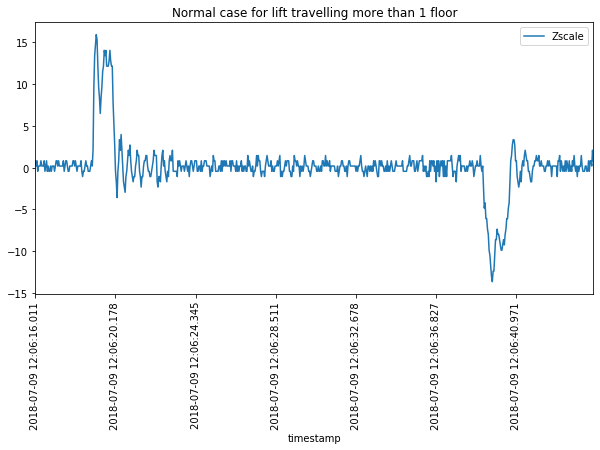

In [35]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift travelling more than 1 floor")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 <a list of 10 Text xticklabel objects>)

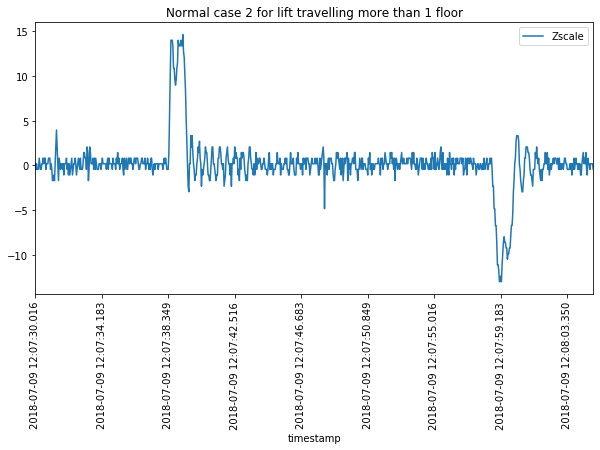

In [48]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case 2 for lift travelling more than 1 floor")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 <a list of 10 Text xticklabel objects>)

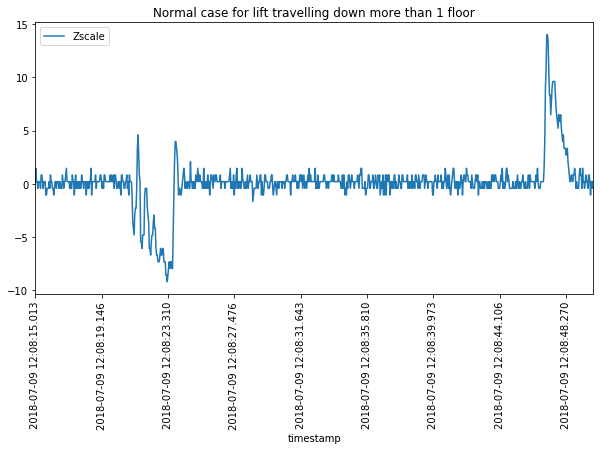

In [61]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift travelling down more than 1 floor")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 <a list of 9 Text xticklabel objects>)

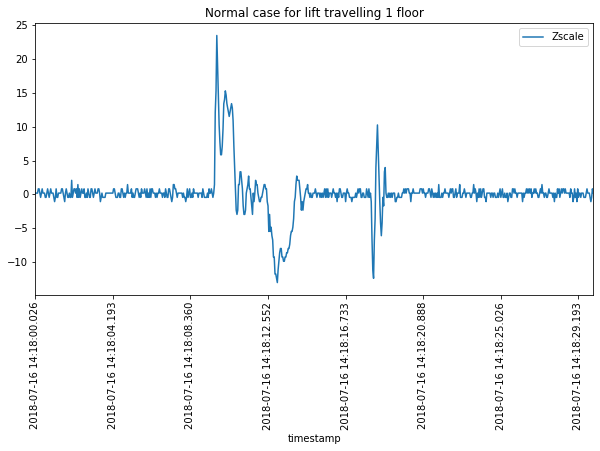

In [119]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift travelling 1 floor")
plt.xticks(rotation=90)

### Plots of Anomalies detected for Lift 4. 10 different anomalies are plotted here

### Plots of Anomalies 1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

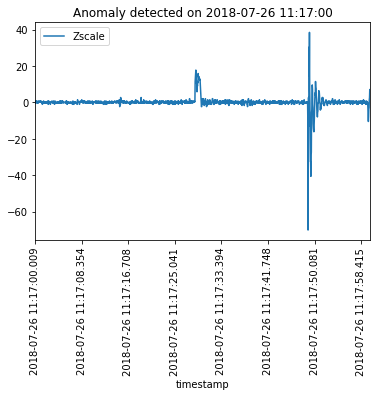

In [42]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-26 11:17:00")
plt.xticks(rotation=90)

In [43]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.35 s, sys: 0 ns, total: 2.35 s
Wall time: 5.36 s


(array([736901.47013889, 736901.47025463, 736901.47037037, 736901.47048611,
        736901.47060185, 736901.47071759]),
 <a list of 6 Text xticklabel objects>)

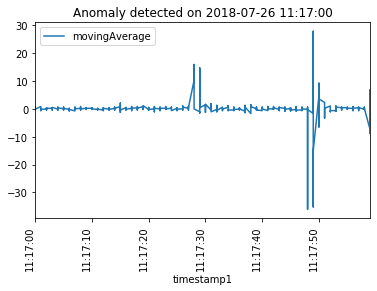

In [44]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-26 11:17:00")
plt.xticks(rotation=90)

### Plots of Anomalies 2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

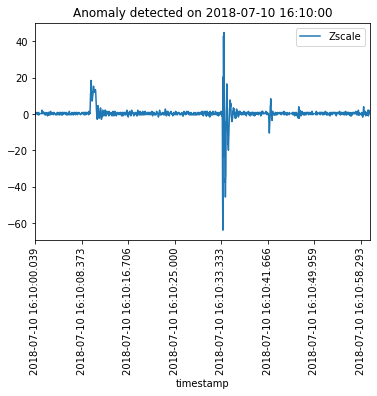

In [50]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-10 16:10:00")
plt.xticks(rotation=90)

In [51]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.45 s, sys: 0 ns, total: 2.45 s
Wall time: 5.23 s


(array([736885.67361111, 736885.67372685, 736885.67384259, 736885.67395833,
        736885.67407407, 736885.67418981]),
 <a list of 6 Text xticklabel objects>)

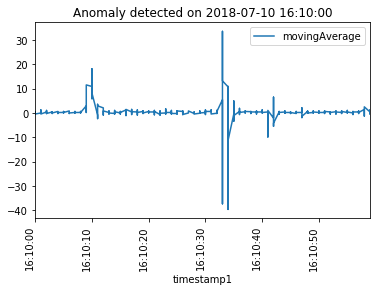

In [52]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-10 16:10:00")
plt.xticks(rotation=90)

### Plots of Anomalies 3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

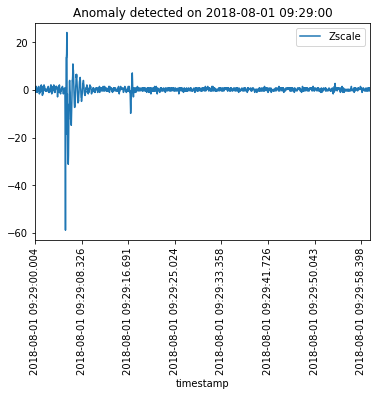

In [58]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-01 09:29:00")
plt.xticks(rotation=90)

In [59]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.09 s, sys: 16.4 ms, total: 2.1 s
Wall time: 4.85 s


(array([736907.39513889, 736907.39525463, 736907.39537037, 736907.39548611,
        736907.39560185, 736907.39571759]),
 <a list of 6 Text xticklabel objects>)

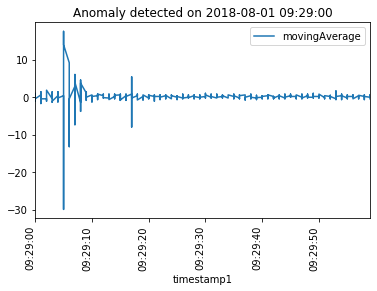

In [60]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-01 09:29:00")
plt.xticks(rotation=90)

### Plots of Anomalies 4

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

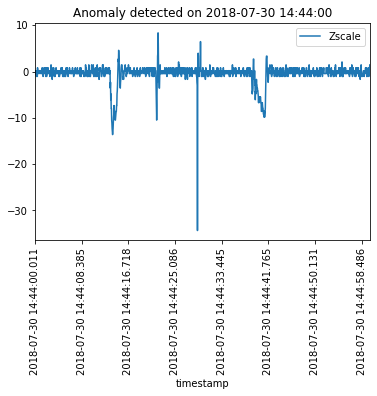

In [66]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-30 14:44:00")
plt.xticks(rotation=90)

In [67]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.22 s, sys: 71.4 ms, total: 2.29 s
Wall time: 5.19 s


(array([736905.61388889, 736905.61400463, 736905.61412037, 736905.61423611,
        736905.61435185, 736905.61446759]),
 <a list of 6 Text xticklabel objects>)

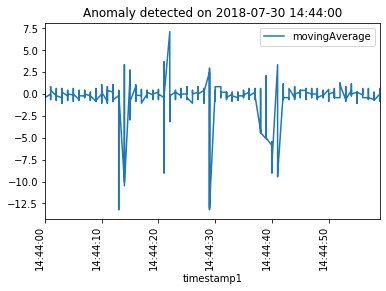

In [68]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-30 14:44:00")
plt.xticks(rotation=90)

### Plots of Anomalies 5

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

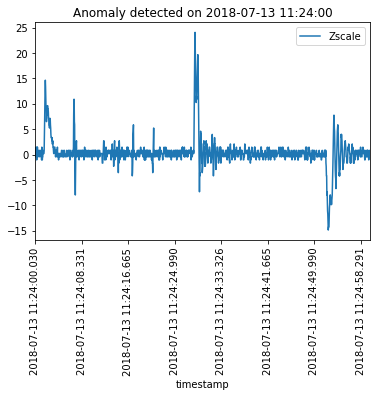

In [74]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 11:24:00")
plt.xticks(rotation=90)

In [75]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 1.67 s, sys: 92.9 ms, total: 1.76 s
Wall time: 4.05 s


(array([736888.475     , 736888.47511574, 736888.47523148, 736888.47534722,
        736888.47546296, 736888.4755787 ]),
 <a list of 6 Text xticklabel objects>)

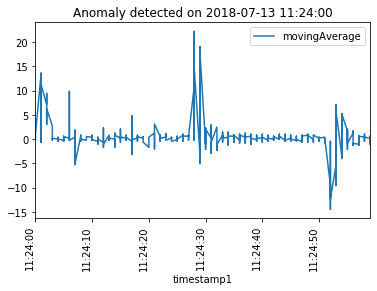

In [76]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 11:24:00")
plt.xticks(rotation=90)

### Plots of Anomalies 6

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

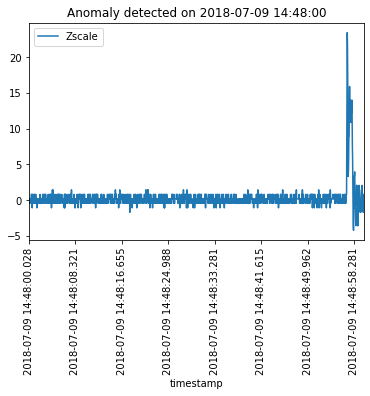

In [82]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-09 14:48:00")
plt.xticks(rotation=90)

In [83]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.31 s, sys: 94.5 ms, total: 2.41 s
Wall time: 4.55 s


(array([736884.61666667, 736884.61678241, 736884.61689815, 736884.61701389,
        736884.61712963, 736884.61724537]),
 <a list of 6 Text xticklabel objects>)

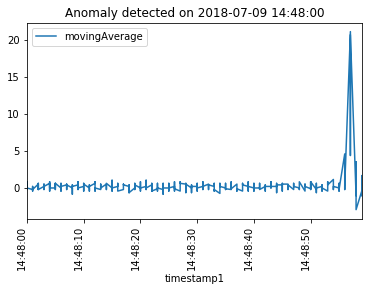

In [84]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-09 14:48:00")
plt.xticks(rotation=90)

### Plots of Anomalies 7

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

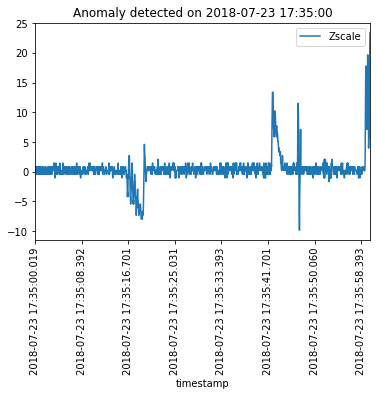

In [92]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-23 17:35:00")
plt.xticks(rotation=90)

In [93]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.19 s, sys: 73.1 ms, total: 2.27 s
Wall time: 4.62 s


(array([736898.73263889, 736898.73275463, 736898.73287037, 736898.73298611,
        736898.73310185, 736898.73321759]),
 <a list of 6 Text xticklabel objects>)

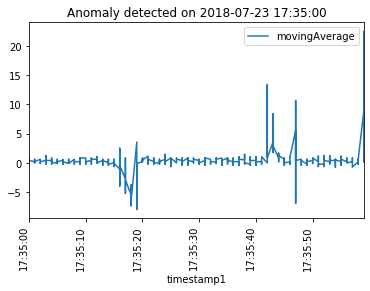

In [94]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-23 17:35:00")
plt.xticks(rotation=90)

### Plots of Anomalies 8

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

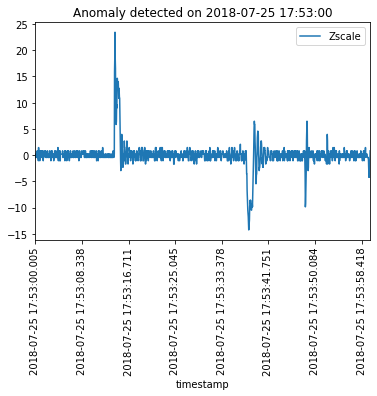

In [100]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-25 17:53:00")
plt.xticks(rotation=90)

In [101]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.22 s, sys: 90.2 ms, total: 2.31 s
Wall time: 4.78 s


(array([736900.74513889, 736900.74525463, 736900.74537037, 736900.74548611,
        736900.74560185, 736900.74571759]),
 <a list of 6 Text xticklabel objects>)

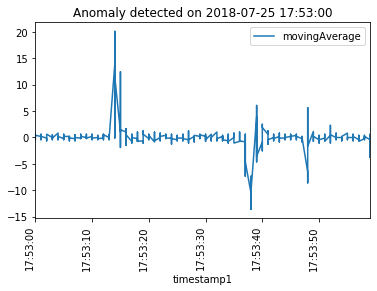

In [102]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-25 17:53:00")
plt.xticks(rotation=90)

### Plots of Anomalies 9

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

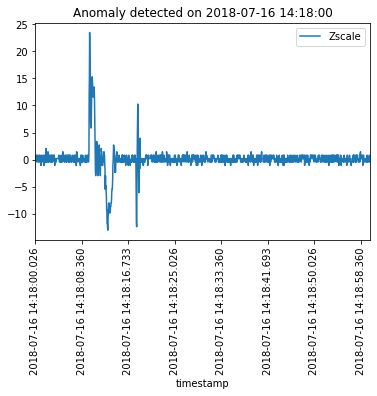

In [108]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 14:18:00")
plt.xticks(rotation=90)

In [109]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.14 s, sys: 159 ms, total: 2.3 s
Wall time: 4.61 s


(array([736891.59583333, 736891.59594907, 736891.59606481, 736891.59618056,
        736891.5962963 , 736891.59641204]),
 <a list of 6 Text xticklabel objects>)

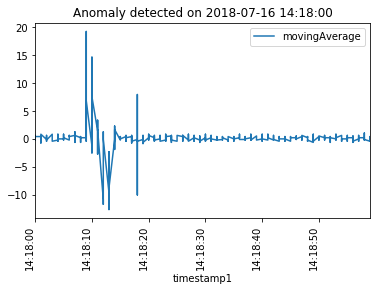

In [110]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-16 14:18:00")
plt.xticks(rotation=90)

### Plots of Anomalies 10

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

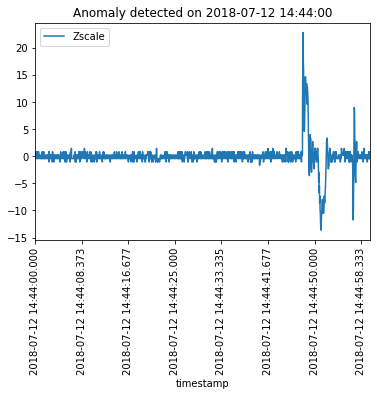

In [34]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 14:44:00")
plt.xticks(rotation=90)

In [35]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 2.21 s, sys: 0 ns, total: 2.21 s
Wall time: 5.92 s


(array([736887.61388889, 736887.61400463, 736887.61412037, 736887.61423611,
        736887.61435185, 736887.61446759]),
 <a list of 6 Text xticklabel objects>)

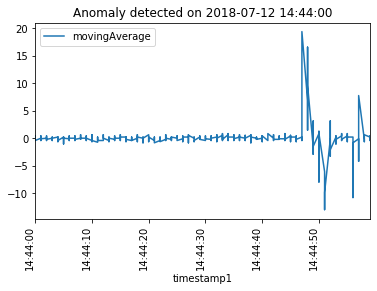

In [36]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 14:44:00")
plt.xticks(rotation=90)